In [2]:
pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=e8bd581b72043b0eebda80f9f5c1188973d7fd1238d2117c1d89180d691f203a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch
Note: you may need to restart the kernel to use updated packages.


In [3]:
# General Libraries
import re
import gc
import os
import cv2
import copy
import math
import shutil
from tqdm import tqdm
from time import time
import datetime as dtime
from pprint import pprint
from sklearn.utils import shuffle
from datetime import datetime, timedelta
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import albumentations as A
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn import BCEWithLogitsLoss
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

# PyTorch
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.pytorch import ToTensorV2
# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize, RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise, Rotate, RandomResizedCrop, ShiftScaleRotate, ToGray)

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='albumentations')

import logging
logging.getLogger('albumentations').setLevel(logging.ERROR)

# Custom colors
class Color:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'

In [4]:
train = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
# Get image path
base_path = "/kaggle/working/Processed Image/"
all_paths = []
for k in tqdm(range(len(train))):
    row = train.iloc[k, :]
    all_paths.append(base_path + str(row.patient_id) + "/" + str(row.image_id) + ".png")
    
train["path_image_processed"] = all_paths

display(train.head())

100%|██████████| 54706/54706 [00:07<00:00, 7601.91it/s]


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,path_image_processed
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/working/Processed Image/10006/46282261...
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/working/Processed Image/10006/14595417...
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/working/Processed Image/10006/18645908...
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,/kaggle/working/Processed Image/10006/18749465...
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,/kaggle/working/Processed Image/10011/22037523...


In [5]:
def prepare_data(data, kaggle_path):
    # Map the 'cancer' column to a new 'labels' column
    data['labels'] = data['cancer'].map({0: 'No Cancer', 1: 'Cancer'})
    print("Mapped 'cancer' column to 'labels' column.")

    # Check the number of missing values in the 'age' column before filling
    missing_before = data['age'].isnull().sum()
    print("Number of missing values in 'age' before filling:", missing_before)

    # Fill missing values in the 'age' column with 58
    data['age'] = data['age'].fillna(58)
    print("Filled missing values in 'age' column with 58.")

    # Check the number of missing values in the 'age' column after filling
    missing_after = data['age'].isnull().sum()
    print("Number of missing values in 'age' after filling:", missing_after)

    # Select specified columns
    features = ["patient_id", "image_id", "laterality", "view", "age", "implant", "cancer", "labels", "path_image_processed"]
    data = data[features]
    print("Selected specified columns.")
    
    data = tranform_categorical(data.copy())

    # Path to save the CSV file
    path_saved = os.path.join(kaggle_path, 'train_clean.csv')
    print(f"Path to save the CSV file: {path_saved}")

    # Save the cleaned data to CSV
    data.to_csv(path_saved, index=False)
    print("Saved the cleaned data to CSV.")

    return data

def tranform_categorical(data):
    """
    Encode categorical variables in the dataset.
    
    Parameters:
    - data: A pandas DataFrame containing the data with categorical variables 'laterality' and 'view'.
    
    Returns:
    - data: A pandas DataFrame with the categorical variables encoded as integers.
    """
    # Initialize LabelEncoders for categorical variables
    le_laterality = LabelEncoder()
    le_view = LabelEncoder()

    # Encode 'laterality' and 'view' columns
    data['laterality'] = le_laterality.fit_transform(data['laterality'])
    data['view'] = le_view.fit_transform(data['view'])

    return data

In [23]:
kaggle_path = '/kaggle/working/'
data = train.copy()
cleaned_data = prepare_data(data.copy(), kaggle_path)
display(cleaned_data.head())

Mapped 'cancer' column to 'labels' column.
Number of missing values in 'age' before filling: 37
Filled missing values in 'age' column with 58.
Number of missing values in 'age' after filling: 0
Selected specified columns.
Path to save the CSV file: /kaggle/working/train_clean.csv
Saved the cleaned data to CSV.


,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,10006,462822612,0,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/46282261...
1,10006,1459541791,0,5,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/14595417...
2,10006,1864590858,1,5,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/18645908...
3,10006,1874946579,1,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/18749465...
4,10011,220375232,0,1,55.0,0,0,No Cancer,/kaggle/working/Processed Image/10011/22037523...


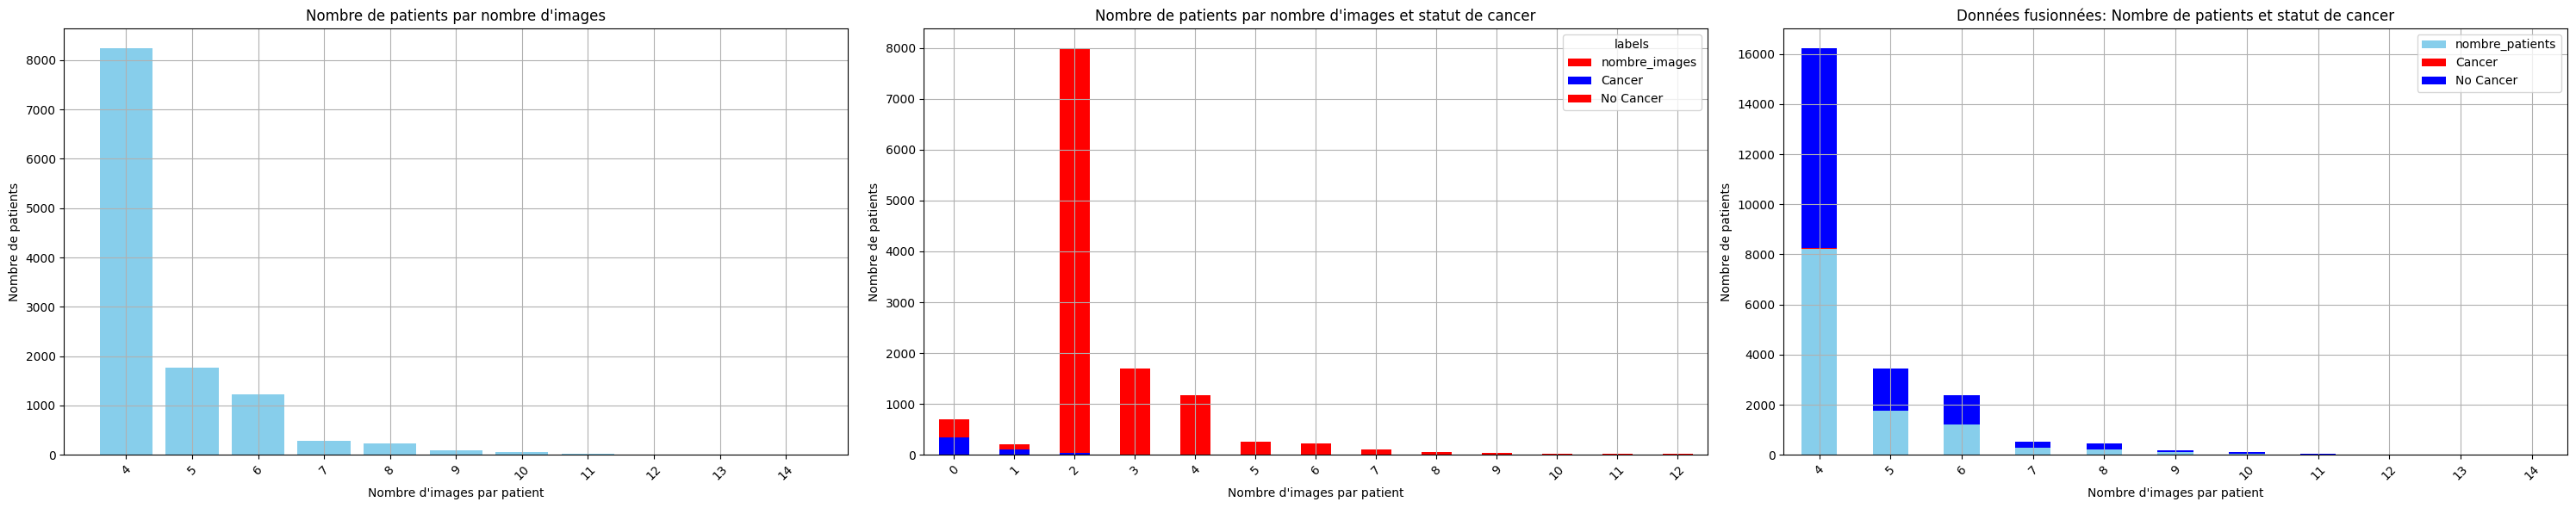

In [37]:
data = cleaned_data.copy()

# Étape 1: Compter le nombre d'images par patient
patient_image_count = data.groupby('patient_id').size()

# Créer un DataFrame pour le comptage des images par patient
image_count_df = patient_image_count.value_counts().reset_index()
image_count_df.columns = ['nombre_images', 'nombre_patients']
image_count_df = image_count_df.sort_values('nombre_images')

# Étape 2: Ajouter une segmentation par cancer
# data['cancer'] = data['cancer'].apply(lambda x: 'Cancer' if x == 1 else 'No Cancer')

# Compter le nombre d'images par patient et par statut de cancer
patient_image_cancer_count = data.groupby(['patient_id', 'labels']).size().reset_index(name='count')
image_cancer_count_df = patient_image_cancer_count.groupby(['count', 'labels']).size().unstack(fill_value=0)

# Renommer la colonne pour correspondre à celle de image_count_df
image_cancer_count_df = image_cancer_count_df.rename_axis('nombre_images').reset_index()

# Étape 3: Fusionner les deux DataFrames
merged_df = pd.merge(image_count_df, image_cancer_count_df, on='nombre_images', how='left')

# Créer une figure avec trois sous-graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(30, 6))

# Sous-graphe 1: Nombre de patients par nombre d'images
axes[0].bar(image_count_df['nombre_images'], image_count_df['nombre_patients'], color='skyblue')
axes[0].set_xlabel('Nombre d\'images par patient')
axes[0].set_ylabel('Nombre de patients')
axes[0].set_title('Nombre de patients par nombre d\'images')
axes[0].set_xticks(image_count_df['nombre_images'])
axes[0].set_xticklabels(image_count_df['nombre_images'], rotation=45)
axes[0].grid(True)

# Sous-graphe 2: Visualisation segmentée par cancer
image_cancer_count_df.plot(kind='bar', stacked=True, color=['red', 'blue'], ax=axes[1])
axes[1].set_xlabel('Nombre d\'images par patient')
axes[1].set_ylabel('Nombre de patients')
axes[1].set_title('Nombre de patients par nombre d\'images et statut de cancer')
axes[1].set_xticks(range(len(image_cancer_count_df.index)))
axes[1].set_xticklabels(image_cancer_count_df.index, rotation=45)
axes[1].grid(True)

# Sous-graphe 3: Visualisation des données fusionnées
merged_df.plot(kind='bar', x='nombre_images', stacked=True, ax=axes[2], color=['skyblue', 'red', 'blue'])
axes[2].set_xlabel('Nombre d\'images par patient')
axes[2].set_ylabel('Nombre de patients')
axes[2].set_title('Données fusionnées: Nombre de patients et statut de cancer')
axes[2].set_xticks(range(len(merged_df['nombre_images'])))
axes[2].set_xticklabels(merged_df['nombre_images'], rotation=45)
axes[2].grid(True)

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()


In [8]:
# Affichage du DataFrame fusionné
display(merged_df)

,nombre_images,nombre_patients,Cancer,No Cancer
0,4,8233,29,7953
1,5,1767,7,1683
2,6,1218,0,1158
3,7,276,0,258
4,8,229,0,221
5,9,99,0,92
6,10,53,0,52
7,11,19,0,19
8,12,12,0,12
9,13,5,0,5


In [25]:
display(data)

,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
0,10006,462822612,0,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/46282261...
1,10006,1459541791,0,5,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/14595417...
2,10006,1864590858,1,5,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/18645908...
3,10006,1874946579,1,1,61.0,0,0,No Cancer,/kaggle/working/Processed Image/10006/18749465...
4,10011,220375232,0,1,55.0,0,0,No Cancer,/kaggle/working/Processed Image/10011/22037523...
...,...,...,...,...,...,...,...,...,...
54701,9973,1729524723,1,5,43.0,0,0,No Cancer,/kaggle/working/Processed Image/9973/172952472...
54702,9989,63473691,0,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/63473691.png
54703,9989,1078943060,0,1,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/107894306...
54704,9989,398038886,1,5,60.0,0,0,No Cancer,/kaggle/working/Processed Image/9989/398038886...


je souhaite diviser mon dataset en fonction de :
divise le dataset en deux train et test:
envoi dans le test tous les patients ayant un nombre d'image superieur ou egale a 6, a ceci tu devras ajouter, aleatoirement 2 patient avec un nombre images egale a 5 ceci appartenent a la classe Cancer et 4 patient avec un nombre images egale a 4 les deux appartenent a la classe Cancer du dataset, et le reste dans le train.
voici comment tu vas former le train, dans train met le reste en exluant les image des patient que tu as envoit dans le test

voici juste une vu simplifier de dataset mais le data
	patient_id	image_id	laterality	view	age	implant	cancer	labels	path_image_processed
0	10006	462822612	0	1	61.0	0	0	No Cancer	/kaggle/working/Processed Image/10006/46282261...
1	10006	1459541791	0	5	61.0	0	0	No Cancer	/kaggle/working/Processed Image/10006/14595417...
2	10006	1864590858	1	5	61.0	0	0	No Cancer	/kaggle/working/Processed Image/10006/18645908...
3	10006	1874946579	1	1	61.0	0	0	No Cancer	/kaggle/working/Processed Image/10006/18749465...
4	10011	220375232	0	1	55.0	0	0	No Cancer	/kaggle/working/Processed Image/10011/22037523...


In [32]:
display(merged_df)

,nombre_images,nombre_patients,Cancer,No Cancer
0,4,8233,29,7953
1,5,1767,7,1683
2,6,1218,0,1158
3,7,276,0,258
4,8,229,0,221
5,9,99,0,92
6,10,53,0,52
7,11,19,0,19
8,12,12,0,12
9,13,5,0,5


In [40]:
# Compter le nombre d'images par patient
patient_counts = data.groupby('patient_id').size().reset_index(name='image_count')

# Séparer les patients en fonction du nombre d'images
patients_with_6_or_more_images = patient_counts[patient_counts['image_count'] >= 6]
patients_with_5_images = patient_counts[(patient_counts['image_count'] == 5)]
print(f'patients_with_5_images: {len(patients_with_5_images)}')
patients_with_4_images = patient_counts[(patient_counts['image_count'] == 4)]
print(f'patients_with_4_images: {len(patients_with_4_images)}')

print('')

# Sélection aléatoire de patients avec 5 et 4 images qui ont la classe "Cancer"
cancer_patients_5_images = data[data['patient_id'].isin(patients_with_5_images['patient_id']) & (data['cancer'] == 1)]['patient_id'].unique()
print(f'cancer_patients_5_images: {len(cancer_patients_5_images)}')
cancer_patients_4_images = data[data['patient_id'].isin(patients_with_4_images['patient_id']) & (data['cancer'] == 1)]['patient_id'].unique()
print(f'cancer_patients_4_images: {len(cancer_patients_4_images)}')

selected_5_image_patients = random.sample(list(cancer_patients_5_images), 2)
selected_4_image_patients = random.sample(list(cancer_patients_4_images), 4)

# Combine all patients for the test set
test_patient_ids = list(patients_with_6_or_more_images['patient_id']) + selected_5_image_patients + selected_4_image_patients

# Créer les ensembles train et test
test_set = data[data['patient_id'].isin(test_patient_ids)]
train_set = data[~data['patient_id'].isin(test_patient_ids)]



patients_with_5_images: 1767
patients_with_4_images: 8233

cancer_patients_5_images: 89
cancer_patients_4_images: 303


In [41]:
selected_5_image_patients

[65224, 53343]

In [46]:
data[data['patient_id']==65224]

,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
51238,65224,103907988,0,1,42.0,0,0,No Cancer,/kaggle/working/Processed Image/65224/10390798...
51239,65224,260085695,0,5,42.0,0,0,No Cancer,/kaggle/working/Processed Image/65224/26008569...
51240,65224,733985046,0,5,42.0,0,0,No Cancer,/kaggle/working/Processed Image/65224/73398504...
51241,65224,200271231,1,5,42.0,0,1,Cancer,/kaggle/working/Processed Image/65224/20027123...
51242,65224,1876649852,1,1,42.0,0,1,Cancer,/kaggle/working/Processed Image/65224/18766498...


In [45]:
data[data['patient_id']==53343]

,patient_id,image_id,laterality,view,age,implant,cancer,labels,path_image_processed
40111,53343,463687047,0,1,77.0,0,1,Cancer,/kaggle/working/Processed Image/53343/46368704...
40112,53343,1141466623,0,5,77.0,0,1,Cancer,/kaggle/working/Processed Image/53343/11414666...
40113,53343,1721695713,0,5,77.0,0,1,Cancer,/kaggle/working/Processed Image/53343/17216957...
40114,53343,763202553,1,5,77.0,0,0,No Cancer,/kaggle/working/Processed Image/53343/76320255...
40115,53343,1182549552,1,1,77.0,0,0,No Cancer,/kaggle/working/Processed Image/53343/11825495...


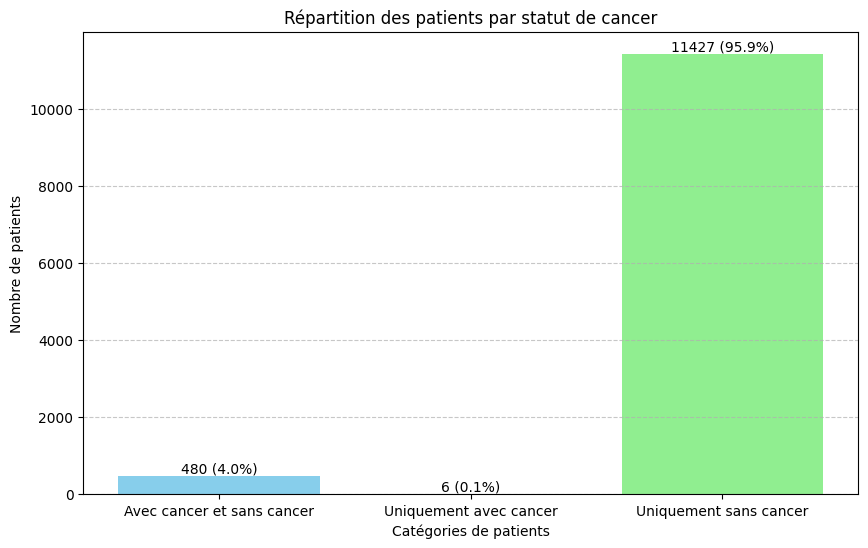

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger les données
# data = pd.read_csv("path_to_your_dataset.csv")  # Remplacez par le chemin réel de votre dataset

# Identifier les patients ayant des images avec et sans cancer
patients_cancer = data[data['cancer'] == 1]['patient_id'].unique()
patients_no_cancer = data[data['cancer'] == 0]['patient_id'].unique()

patients_with_both = set(patients_cancer) & set(patients_no_cancer)
patients_with_only_cancer = set(patients_cancer) - set(patients_no_cancer)
patients_with_only_no_cancer = set(patients_no_cancer) - set(patients_cancer)

# Comptage des patients dans chaque catégorie
num_patients_with_both = len(patients_with_both)
num_patients_with_only_cancer = len(patients_with_only_cancer)
num_patients_with_only_no_cancer = len(patients_with_only_no_cancer)

# Calcul du total de patients pour les pourcentages
total_patients = num_patients_with_both + num_patients_with_only_cancer + num_patients_with_only_no_cancer

# Calcul des pourcentages
percent_with_both = (num_patients_with_both / total_patients) * 100
percent_with_only_cancer = (num_patients_with_only_cancer / total_patients) * 100
percent_with_only_no_cancer = (num_patients_with_only_no_cancer / total_patients) * 100

# Créer le graphique en barres
categories = ['Avec cancer et sans cancer', 'Uniquement avec cancer', 'Uniquement sans cancer']
counts = [num_patients_with_both, num_patients_with_only_cancer, num_patients_with_only_no_cancer]
percentages = [percent_with_both, percent_with_only_cancer, percent_with_only_no_cancer]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['skyblue', 'lightcoral', 'lightgreen'])

# Ajouter les valeurs absolues et les pourcentages sur les barres
for bar, count, pct in zip(bars, counts, percentages):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{count} ({pct:.1f}%)',
             ha='center', va='bottom')

plt.title('Répartition des patients par statut de cancer')
plt.ylabel('Nombre de patients')
plt.xlabel('Catégories de patients')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [51]:
# Charger les données
# data = pd.read_csv("path_to_your_dataset.csv")  # Remplacez par le chemin réel de votre dataset

# Identifier les patients ayant des images avec et sans cancer
patients_cancer = data[data['cancer'] == 1]['patient_id'].unique()
patients_no_cancer = data[data['cancer'] == 0]['patient_id'].unique()

patients_with_both = set(patients_cancer) & set(patients_no_cancer)
patients_with_only_cancer = set(patients_cancer) - set(patients_no_cancer)
patients_with_only_no_cancer = set(patients_no_cancer) - set(patients_cancer)

# Comptage des patients dans chaque catégorie
num_patients_with_both = len(patients_with_both)
num_patients_with_only_cancer = len(patients_with_only_cancer)
num_patients_with_only_no_cancer = len(patients_with_only_no_cancer)

# Calcul du total de patients pour les pourcentages
total_patients = num_patients_with_both + num_patients_with_only_cancer + num_patients_with_only_no_cancer

# Calcul des pourcentages
percent_with_both = (num_patients_with_both / total_patients) * 100
percent_with_only_cancer = (num_patients_with_only_cancer / total_patients) * 100
percent_with_only_no_cancer = (num_patients_with_only_no_cancer / total_patients) * 100

# Création du dataframe
data_summary = pd.DataFrame({
    'Category': ['Avec cancer et sans cancer', 'Uniquement avec cancer', 'Uniquement sans cancer'],
    'Patient Count': [num_patients_with_both, num_patients_with_only_cancer, num_patients_with_only_no_cancer],
    'Percentage': [percent_with_both, percent_with_only_cancer, percent_with_only_no_cancer]
})

# Affichage du dataframe
display(data_summary)


,Category,Patient Count,Percentage
0,Avec cancer et sans cancer,480,4.029212
1,Uniquement avec cancer,6,0.050365
2,Uniquement sans cancer,11427,95.920423


In [35]:
data = train_set.copy()

# Étape 1: Compter le nombre d'images par patient
patient_image_count = data.groupby('patient_id').size()

# Créer un DataFrame pour le comptage des images par patient
image_count_df = patient_image_count.value_counts().reset_index()
image_count_df.columns = ['nombre_images', 'nombre_patients']
image_count_df = image_count_df.sort_values('nombre_images')

# Étape 2: Ajouter une segmentation par cancer
# data['cancer'] = data['cancer'].apply(lambda x: 'Cancer' if x == 1 else 'No Cancer')

# Compter le nombre d'images par patient et par statut de cancer
patient_image_cancer_count = data.groupby(['patient_id', 'labels']).size().reset_index(name='count')
image_cancer_count_df = patient_image_cancer_count.groupby(['count', 'labels']).size().unstack(fill_value=0)

# Renommer la colonne pour correspondre à celle de image_count_df
image_cancer_count_df = image_cancer_count_df.rename_axis('nombre_images').reset_index()

# Étape 3: Fusionner les deux DataFrames
merged_df = pd.merge(image_count_df, image_cancer_count_df, on='nombre_images', how='left')
merged_df

,nombre_images,nombre_patients,Cancer,No Cancer
0,4,8229,6,7930
1,5,1765,0,1678


In [34]:
selected_4_image_patients

[7493, 56713, 9707, 34676]

In [29]:
test_set.shape

(12965, 9)

In [31]:
train_set.shape

(41741, 9)

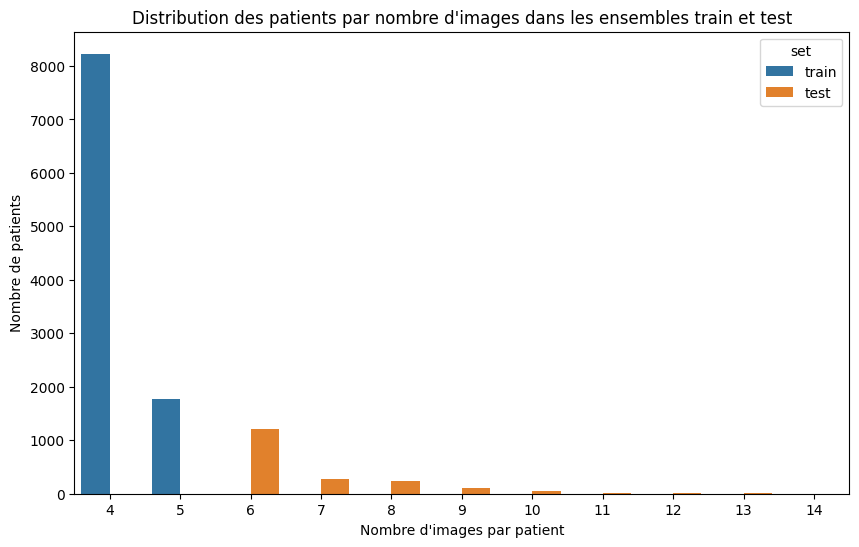

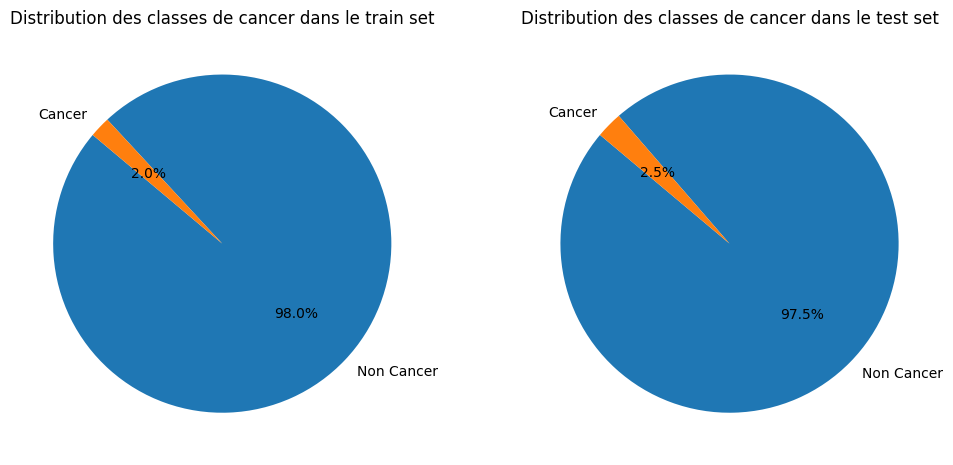

In [27]:
import seaborn as sns


# Compter le nombre de patients par nombre d'images pour chaque set
train_patient_counts = train_set.groupby('patient_id').size().reset_index(name='image_count')
test_patient_counts = test_set.groupby('patient_id').size().reset_index(name='image_count')

# Ajouter une colonne pour distinguer les ensembles
train_patient_counts['set'] = 'train'
test_patient_counts['set'] = 'test'

# Concaténer les deux dataframes pour visualisation
combined_counts = pd.concat([train_patient_counts, test_patient_counts])

# Graphique en barres du nombre de patients par nombre d'images
plt.figure(figsize=(10, 6))
sns.countplot(x='image_count', hue='set', data=combined_counts)
plt.title('Distribution des patients par nombre d\'images dans les ensembles train et test')
plt.xlabel('Nombre d\'images par patient')
plt.ylabel('Nombre de patients')
plt.show()

# Diagramme circulaire pour la répartition des classes de cancer
train_cancer_distribution = train_set['cancer'].value_counts()
test_cancer_distribution = test_set['cancer'].value_counts()

plt.figure(figsize=(12, 6))

# Train set
plt.subplot(1, 2, 1)
plt.pie(train_cancer_distribution, labels=['Non Cancer', 'Cancer'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution des classes de cancer dans le train set')

# Test set
plt.subplot(1, 2, 2)
plt.pie(test_cancer_distribution, labels=['Non Cancer', 'Cancer'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution des classes de cancer dans le test set')

plt.show()


In [27]:
def plot_cases_count(df, title, ax):
    # Count the number of occurrences for each label and sort by index
    cases_count = df['labels'].value_counts().sort_index()

    # Create a bar plot with a custom color palette
    palette = sns.color_palette(["#1f77b4", "#ff7f0e"])  # Custom colors: blue and orange
    sns.barplot(x=cases_count.index, y=cases_count.values, ax=ax, palette=palette)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Case Type', fontsize=12)
    ax.set_ylabel('Number of Cases', fontsize=12)
    ax.set_xticks(range(len(cases_count.index)))
    ax.set_xticklabels(cases_count.index, fontsize=12)
    
    # Add annotations for each bar
    for i, count in enumerate(cases_count.values):
        ax.text(i, count, f'{count}', ha='center', va='bottom', fontsize=10, color='black')

def plot_label_distribution(train,dataset_type='Train'):
    """
    Plot the distribution of labels in the DataFrame `train`.

    Parameters:
    train (pd.DataFrame): DataFrame containing the label data.

    The DataFrame must have a column named 'labels'.
    """
    counts = train['labels'].value_counts()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # First subplot: bar chart
    bars = ax1.bar(counts.index, counts.values, color=sns.color_palette("pastel"))

    # Format the number with commas and display it above the bars
    for bar in bars:
        height = bar.get_height()
        percentage = (height / len(train)) * 100  # Calculate the percentage
        ax1.text(bar.get_x() + bar.get_width() / 2, height + (max(counts.values) * 0.02), 
                 f"{height:,.0f}\n({percentage:.1f}%)", ha='center', va='bottom', color='black', fontsize=10)

    #ax1.set_xlabel('Different types of labels in the Cancer column',loc='center')
    ax1.set_ylabel('Frequency')
    #ax1.set_title('Analysis of the target column Cancer', color='red')
    ax1.set_title(f'{dataset_type.capitalize()} Dataset: Analysis of the target column Cancer', color='red')

    # Show both horizontal and vertical grid lines
    ax1.grid(axis='both', linestyle='-', alpha=0.5)

    # Adjust y-limit to ensure text fits within the figure
    ax1.set_ylim(0, max(counts.values) * 1.2)

    # Second subplot: pie chart
    wedges, texts, autotexts = ax2.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90, 
                                       colors=sns.color_palette("pastel"), textprops=dict(color="w"))

    for text in texts:
        text.set_color('black')
    
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontsize(10)
    
    #ax2.set_title('Distribution of labels', color='blue')
    ax2.set_title(f'{dataset_type.capitalize()} Dataset: Distribution of labels', color='red')

    # Adjust spacing between the two subplots
    plt.subplots_adjust(wspace=0.1)

    # Add a text box with the message
    message = f'The {dataset_type} dataset has {len(train)} samples with the following label distribution.'
    plt.figtext(0.5, 0.01, message, wrap=True, horizontalalignment='center', fontsize=11, color='black')

    plt.show()

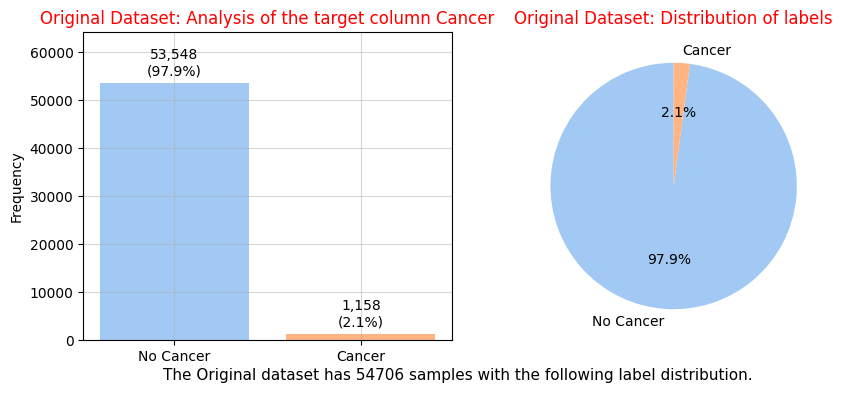

In [28]:
plot_label_distribution(cleaned_data,'Original')

In [101]:
class My_Custom_RSNA_Dataset(Dataset): 
    def __init__(self, dataframe, csv_columns, transform=None, resize_dims=(224, 224)):
        self.dataframe = dataframe
        self.csv_columns = csv_columns
        self.resize_dims = resize_dims  # Set desired resize dimensions (width, height)
        
        # Data Augmentation (custom for each dataset type)
        # Use provided transform if available, otherwise default to basic tensor conversion
        self.transform = transform if transform else Compose([ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        '''Take each row in batch at a time.'''
        # Select path and read image
        image_path = self.dataframe['path_image_processed'][index]
        
        # Read image from the path
        image = cv2.imread(image_path)
        
        # Resize the image to specified dimensions
        image = cv2.resize(image, self.resize_dims)
        
        # Normalize pixel values to the range [0, 1]
        image = image.astype(np.float32) / 255.0

        # Apply transforms
        transf_image = self.transform(image=image)['image']

        # Import .csv information
        csv_data = np.array(self.dataframe.iloc[index][self.csv_columns].values, dtype=np.float32)

        # Return information, note: no target since it's test data
        return {"image": transf_image,"meta": csv_data,"target": self.dataframe['cancer'][index]}


In [39]:
def set_seed(seed=42):
    """
    Set the seed for generating random numbers.
    
    Args:
        seed (int): The seed to use for the random number generators.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def data_to_device(data):
    """
    Transfer data to the specified device (e.g., CPU or GPU).

    Args:
    data (tuple): A tuple containing the data components to be transferred to the device.
                  Typically, it consists of image, metadata, and targets.

    Returns:
    tuple: A tuple containing the transferred data components, now residing on the specified device.
    """
    # Extract components from the input tuple
    image, metadata, targets = data.values()
    
    # Transfer each component to the specified device
    return image.to(DEVICE), metadata.to(DEVICE), targets.to(DEVICE)

In [40]:
#torch.cuda.empty_cache()


In [41]:
# ----- GLOBAL PARAMS ------
csv_columns = ['laterality', 'view', 'age', 'implant']
no_columns = len(csv_columns)
output_size = 1
# --------------------------
# Use the set_seed function to initialize the seed
set_seed()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', DEVICE)

Device available now: cuda


In [42]:
# Sample data
sample = train_data.head(10) #train_data, test_data

# Instantiate Dataset object
dataset = My_Custom_RSNA_Dataset(sample,csv_columns) #CustomRSNADataset(sample,csv_columns,is_train=True)

# The Dataloader
dataloader = DataLoader(dataset, batch_size=5, shuffle=False,num_workers=4)

# Output of the Dataloader
for k, data in enumerate(dataloader):
    image, meta, targets = data_to_device(data)
    print(Color.S + f"Batch: {k}" + Color.E, "\n" + Color.S + "Image:" + Color.E, image.shape, "\n" + Color.S + "Meta:" + Color.E, meta, "\n" + Color.S + "Targets:" + Color.E, targets, "\n" + "="*50)

Batch: 0 
Image: torch.Size([5, 3, 224, 224]) 
Meta: tensor([[ 0.,  5., 54.,  0.],
        [ 0.,  5., 43.,  0.],
        [ 0.,  1., 60.,  0.],
        [ 1.,  1., 67.,  0.],
        [ 0.,  1., 56.,  1.]], device='cuda:0') 
Targets: tensor([0, 0, 0, 0, 0], device='cuda:0') 
Batch: 1 
Image: torch.Size([5, 3, 224, 224]) 
Meta: tensor([[ 1.,  1., 52.,  0.],
        [ 0.,  5., 61.,  0.],
        [ 0.,  5., 66.,  0.],
        [ 1.,  1., 88.,  0.],
        [ 0.,  1., 74.,  1.]], device='cuda:0') 
Targets: tensor([0, 0, 0, 0, 0], device='cuda:0') 


In [43]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=(1,1), gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = torch.tensor(alpha)
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, preds, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(torch.flatten(preds), torch.flatten(targets).float())
        logits=nn.Sigmoid()(preds)
        F_loss = (self.alpha[0]*(targets)*((1-logits)**self.gamma)+ self.alpha[1]*(1-targets)*((logits)**self.gamma)) * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [44]:
class EffNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = EfficientNet.from_pretrained('efficientnet-b2')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Sequential(nn.Linear(1408 + 250, self.output_size))
        
        
    def forward(self, image, meta, prints=False):   
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input metadata shape:', meta.shape)
        
        # Image CNN
        image = self.features.extract_features(image)
        image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        meta = self.csv(meta)
        if prints: print('Meta Data:', meta.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_meta_data = torch.cat((image, meta), dim=1)
        if prints: print('Concatenated Data:', image_meta_data.shape)
        
        # CLASSIF
        out = self.classification(image_meta_data)
        if prints: print('Out shape:', out.shape)
        
        return out

In [45]:
# Load Model
EffNetNet_model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# Explanation:
# This line creates an instance of an EfficientNet-based neural network model called 'model_example2'
# and transfers it to the specified device (e.g., CPU or GPU) using the '.to(DEVICE)' method.

# Outputs
out = EffNetNet_model(image, meta, prints=True)

# Explanation:
# This line passes input data (image and metadata) through the 'model_example2' neural network model,
# producing output predictions ('out'). If 'prints' is set to True, additional information may be printed
# during the forward pass of the model.

# Criterion example
#criterion_example = nn.BCEWithLogitsLoss()
criterion_example =FocalLoss(alpha=(50,1))

# Explanation:
# This line creates an instance of the Binary Cross-Entropy (BCE) loss function called 'criterion_example',
# which is commonly used for binary classification tasks. 

# Unsqueeze(1) from shape=[3] to shape=[3, 1]
loss = criterion_example(out, targets.unsqueeze(1).float()) 

# Explanation:
# This line calculates the loss value by comparing the model predictions ('out') with the target labels ('targets').
# Before applying the loss function, the target labels are unsqueezed along dimension 1 using 'unsqueeze(1)' 
# to match the shape of the model predictions. The target labels are also converted to float using '.float()'
# to ensure compatibility with the model predictions.

print("="*50)
print(Color.S+'Loss:'+Color.E, loss.item())

Loaded pretrained weights for efficientnet-b2
Input Image shape: torch.Size([5, 3, 224, 224]) 
Input metadata shape: torch.Size([5, 4])
Features Image shape: torch.Size([5, 1408])
Meta Data: torch.Size([5, 250])
Concatenated Data: torch.Size([5, 1658])
Out shape: torch.Size([5, 1])
Loss: 0.133367121219635


In [30]:
def display_dataset_statistics(train_data, valid_data):
    """
    Displays the statistics of the training and validation datasets.

    Args:
        train_data (pd.DataFrame): The training dataset containing features and labels.
        valid_data (pd.DataFrame): The validation dataset containing features and labels.
    """

        
def display_confusion_matrix(valid_targets, valid_preds_rounded):
    """
    Displays the confusion matrix and classification report for a given set of true labels and predicted labels.

    Args:
        valid_targets (array-like): True labels of the validation set.
        valid_preds_rounded (array-like): Predicted labels of the validation set.
    """
    # Replace 0 with "No Cancer" and 1 with "Cancer" in the predicted and true labels
    y_pred = np.where(np.array(valid_preds_rounded) == 0, "No Cancer", "Cancer")   #valid_predictions)
    y_true = np.where(np.array(valid_targets) == 0, "No Cancer", "Cancer")

    # Classification report
    print("Classification Report:\n", classification_report(y_true, y_pred))

    # Confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred, labels=["No Cancer", "Cancer"])
    categories = ["No Cancer", "Cancer"]
    group_names = ["True Negative", "False Positive", "False Negative", "True Positive"]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Display the confusion matrix with seaborn
    plt.figure(figsize=(7, 5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted Values")
    plt.ylabel("True Values")
    plt.title("Confusion Matrix")
    plt.show()


In [31]:

from sklearn.model_selection import GroupKFold
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10], [11, 12]])
y = np.array([1, 2, 3, 4, 5, 6])
groups = np.array([0, 0, 2, 2, 3, 3])
group_kfold = GroupKFold(n_splits=2)
group_kfold.get_n_splits(X, y, groups)
print(group_kfold)
for i, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, group={groups[train_index]}")
    print(f"  Test:  index={test_index}, group={groups[test_index]}")

GroupKFold(n_splits=2)
Fold 0:
  Train: index=[2 3], group=[2 2]
  Test:  index=[0 1 4 5], group=[0 0 3 3]
Fold 1:
  Train: index=[0 1 4 5], group=[0 0 3 3]
  Test:  index=[2 3], group=[2 2]


In [ ]:
def train_folds(model, train_original):
    # Creates a .txt file that will contain the logs
    # logs == what we also print to console
    f = open(f"logs_{VERSION}.txt", "w+")
    
    # Split in folds
    group_fold = GroupKFold(n_splits = FOLDS)

    # Generate indices to split data into training and test set.
    k_folds = group_fold.split(X = np.zeros(len(train_original)), 
                               y = train_original['cancer'], 
                               groups = train_original['patient_id'].tolist())
    
    # For each fold
    for i, (train_index, valid_index) in enumerate(k_folds):
        
        print(clr.S+f"---------- Fold: {i+1} ----------"+clr.E)
        add_in_file(f"---------- Fold: {i+1} ----------", f)
        
        # 🐝 W&B Tracking
        RUN_CONFIG = CONFIG.copy()
        params = dict(model=MODEL, 
                      version=VERSION,
                      fold=i,
                      epochs=EPOCHS, 
                      batch=BATCH_SIZE1,
                      lr=LR,
                      weight_decay=WD)
        RUN_CONFIG.update(params)
        run = wandb.init(project='RSNA_Breast_Cancer', config=RUN_CONFIG)

        wandb.watch(model, log_freq=100) # 🐝

        # --- Create Instances ---
        # Best ROC score in this fold
        best_roc = None
        # Reset patience before every fold
        patience_f = PATIENCE

        # Optimizer/ Scheduler/ Criterion
        optimizer = torch.optim.Adam(model.parameters(), lr = LR, 
                                     weight_decay=WD)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                      patience=LR_PATIENCE, verbose=True, factor=LR_FACTOR)
        criterion = nn.BCEWithLogitsLoss()


        # --- Read in Data ---
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)

        # Create Data instances
        train = RSNADataset(train_data, vertical_flip, horizontal_flip, 
                            is_train=True)
        valid = RSNADataset(valid_data, vertical_flip, horizontal_flip,
                            is_train=True)

        # Dataloaders
        train_loader = DataLoader(train, batch_size=BATCH_SIZE1, 
                                  shuffle=True, num_workers=WORKERS)
        valid_loader = DataLoader(valid, batch_size=BATCH_SIZE2, 
                                  shuffle=False, num_workers=WORKERS)


        # === EPOCHS ===
        for epoch in range(EPOCHS):
            start_time = time()
            correct = 0
            train_losses = 0

            # === TRAIN ===
            # Sets the module in training mode.
            model.train()

            # For each batch
            for k, data in tqdm(enumerate(train_loader)):
                # Save them to device
                image, meta, targets = data_to_device(data)

                # Clear gradients first; very important
                # usually done BEFORE prediction
                optimizer.zero_grad()

                # Log Probabilities & Backpropagation
                out = model(image, meta)
                loss = criterion(out, targets.unsqueeze(1).float())
                loss.backward()
                optimizer.step()

                # --- Save information after this batch ---
                # Save loss
                train_losses += loss.item()
                wandb.log({"train_loss": loss.item()}, step=epoch) # 🐝
                # From log probabilities to actual probabilities
                train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
                # Number of correct predictions
                correct += (train_preds.cpu() == targets.cpu().unsqueeze(1)).sum().item()

            # Compute Train Accuracy
            train_acc = correct / len(train_index)
            wandb.log({"train_acc": train_acc}) # 🐝


            # === EVAL ===
            # Sets the model in evaluation mode.
            model.eval()

            # Create matrix to store evaluation predictions (for accuracy)
            valid_preds = torch.zeros(size = (len(valid_index), 1),device=DEVICE, dtype=torch.float32)


            # Disables gradients (we need to be sure no optimization happens)
            with torch.no_grad():
                for k, data in tqdm(enumerate(valid_loader)):
                    # Save them to device
                    image, meta, targets = data_to_device(data)

                    out = model(image, meta)
                    pred = torch.sigmoid(out)
                    valid_preds[k*image.shape[0] : k*image.shape[0] + image.shape[0]] = pred

                # Calculate accuracy
                valid_acc = accuracy_score(valid_data['cancer'].values, 
                                           torch.round(valid_preds.cpu()))
                wandb.log({"valid_acc": valid_acc}) # 🐝
                # Calculate ROC
                valid_roc = roc_auc_score(valid_data['cancer'].values, 
                                          valid_preds.cpu())
                wandb.log({"valid_roc": valid_roc}) # 🐝

                # Calculate time on Train + Eval
                duration = str(dtime.timedelta(seconds=time() - start_time))[:7]


                # PRINT INFO
                final_logs = '{} | Epoch: {}/{} | Loss: {:.4} | Acc_tr: {:.3} | Acc_vd: {:.3} | ROC: {:.3}'.\
                                format(duration, epoch+1, EPOCHS, 
                                       train_losses, train_acc, valid_acc, valid_roc)
                add_in_file(final_logs,f)
                print(final_logs)


                # === SAVE MODEL ===

                # Update scheduler (for learning_rate)
                scheduler.step(valid_roc)
                # Name the model
                model_name = f"Fold{i+1}_Epoch{epoch+1}_ValidAcc{valid_acc:.3f}_ROC{valid_roc:.3f}.pth"

                # Update best_roc
                if not best_roc: # If best_roc = None
                    best_roc = valid_roc
                    torch.save(model.state_dict(), model_name)
                    continue

                if valid_roc > best_roc:
                    best_roc = valid_roc
                    # Reset patience (because we have improvement)
                    patience_f = PATIENCE
                    torch.save(model.state_dict(), model_name)
                else:
                    # Decrease patience (no improvement in ROC)
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        stop_logs = 'Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                                    format(best_roc)
                        add_in_file(stop_logs, f)
                        print(stop_logs)
                        break


        # === CLEANING ===
        # Clear memory
        del train, valid, train_loader, valid_loader, image, targets
        gc.collect()
        
        # 🐝 Experiment End for this fold
        wandb.finish()

In [ ]:
def Train_Model_Applying_GroupKFolds(model, train_original, hyperparameters):

In [ ]:
     # Define scheduler
            # Reset patience before every fold
        patience_f = PATIENCE
        
        
                # Optimizer/ Scheduler/ Criterion
        optimizer = torch.optim.Adam(model.parameters(), lr = LR, weight_decay=WD)
        
        

In [ ]:
def Train_Model_Applying_GroupKFolds(model, train_original, hyperparameters):
    # Define the threshold
    threshold = 0.5
    
    # Define loss function and optimizer (Optimizer/ Scheduler/ Criterion)
    criterion = nn.BCEWithLogitsLoss()  # Using Binary Cross Entropy with Logits for binary classification
    
    optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"],weight_decay=hyperparameters["weight_decay"])
        
    scheduler = ReduceLROnPlateau(optimizer, mode=hyperparameters["lr_mode"], factor=hyperparameters["lr_factor"], patience=hyperparameters["lr_patience"], verbose=True)

    # Early stopping parameters
    patience = hyperparameters["early_stopping_patience"]

    
    # Initialize metrics storage for visualization
    train_losses,val_losses,train_accuracies,val_accuracies,best_overall_val_f1_score = [],[],[],[],float('-inf')

    # Split in folds
    group_fold = GroupKFold(n_splits = hyperparameters["folds"])

    # Generate indices to split data into training and test set.
    k_folds = group_fold.split(X = np.zeros(len(train_original)),y = train_original['cancer'],groups = train_original['patient_id'].tolist())

    # Create a log file to store training progress
    log_file_path = create_logs_file(logs_dir, version)

    # Iterate over stratified cross-validation folds
    for fold_idx, (train_index, valid_index) in enumerate(k_folds):

        print(Color.S + f"---------- Fold: {fold_idx+1} ----------" + Color.E)
        add_in_file(f"---------- Fold: {fold_idx + 1} ----------", log_file_path)
        
        # Read in data for the current fold
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        #display_dataset_statistics(train_data, valid_data)
        
        # Create custom datasets for training and validation
        print("Creating Data instances for train, test, and validation datasets:")
        train = My_Custom_RSNA_Dataset(train_data, csv_columns) #CustomRSNADataset(train_data, csv_columns, is_train=True)
        valid = My_Custom_RSNA_Dataset(valid_data, csv_columns) #CustomRSNADataset(valid_data, csv_columns, is_train=True)
        print("Data instances created.")

        # Create DataLoader instances for batching data
        print("Creating DataLoaders for batching data:")
        train_loader = DataLoader(train, batch_size=hyperparameters["train_batch_size"], shuffle=False, num_workers=hyperparameters["num_workers"])
        valid_loader = DataLoader(valid, batch_size=hyperparameters["val_batch_size"], shuffle=False, num_workers=hyperparameters["num_workers"])
        print("DataLoaders created.")

        # Early stopping parameters for this fold
        best_val_f1_score,best_val_roc = None,None
        trigger_times = 0
        best_model_state = None

        # Initialize lists to store metrics for visualization
        fold_train_losses = []
        fold_val_losses = []
        fold_train_accuracies = []
        fold_val_accuracies = []
        
        # Initialisation du modèle
        # model = EffNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)  # Modèle sur le dispositif approprié

        # Training the model
        for epoch in range(hyperparameters["num_epochs"]):
            start_time = time()
            print(f"Training the model")
            model.train()
            train_loss,correct,total = 0,0,0
            train_preds,train_labels = [],[]

            # Progress bar for training
            with tqdm(train_loader, unit="batch") as tepoch:
                tepoch.set_description(f"Epoch {epoch+1}, Training")

                # Iterate over batches in the training DataLoader
                for k, batch in enumerate(tepoch):
                    images, meta, labels = data_to_device(batch)
                    optimizer.zero_grad()
                    outputs = model(images, meta)
                    labels = labels.unsqueeze(1).float()
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    predicted = (torch.sigmoid(outputs) > threshold).float()
                    train_preds.extend(predicted.cpu().numpy())
                    train_labels.extend(labels.cpu().numpy())

                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

                    tepoch.set_postfix(loss=train_loss / total, accuracy=100. * correct / total)

            # Calculate training metrics
            train_loss /= len(train_loader.dataset)
            train_accuracy = accuracy_score(train_labels, train_preds)
            train_roc = roc_auc_score(train_labels, train_preds)
            train_precision = precision_score(train_labels, train_preds)
            train_recall = recall_score(train_labels, train_preds)
            train_f1 = f1_score(train_labels, train_preds)

            fold_train_losses.append(train_loss)
            fold_train_accuracies.append(train_accuracy)

            print(f"Training metrics for Epoch {epoch + 1}:")
            print(f"Train loss: {train_loss:.4f}, Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F1 score: {train_f1}, ROC: {train_roc}")

            # Validate the model's performance on validation set
            print(f"Validating the trained model's performance")
            model.eval()
            val_loss,correct,total = 0,0,0
            val_preds,val_labels = [],[]

            # Progress bar for validation
            with tqdm(test_loader, unit="batch") as vepoch:
                vepoch.set_description(f"Validation {epoch+1}")
                with torch.no_grad():
                    # Iterate over batches in the validation DataLoader
                    for k, batch in enumerate(vepoch):
                        images, meta, labels = data_to_device(batch)
                        outputs = model(images, meta)
                        labels = labels.unsqueeze(1).float()
                        val_loss += criterion(outputs, labels).item()
                        predicted = (torch.sigmoid(outputs) > threshold).float()

                        correct += (predicted == labels).sum().item()
                        total += labels.size(0)

                        val_preds.extend(predicted.cpu().numpy().flatten().tolist())
                        val_labels.extend(labels.cpu().numpy().flatten().tolist())

                        vepoch.set_postfix(loss=val_loss / total, accuracy=100. * correct / total)

            # Calculate validation metrics
            val_loss /= len(valid_loader.dataset)
            val_accuracy = accuracy_score(val_labels, val_preds)
            val_roc = roc_auc_score(val_labels, val_preds)
            val_precision = precision_score(val_labels, val_preds)
            val_recall = recall_score(val_labels, val_preds)
            val_f1 = f1_score(val_labels, val_preds)

            fold_val_losses.append(val_loss)
            fold_val_accuracies.append(val_accuracy)

            print(f"Validation metrics for Epoch {epoch + 1}:")
            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 score: {val_f1}, ROC: {val_roc}")

            # Display confusion matrix
            print("+++++++++ Confusion Matrix for Validation Dataset +++++++++")
            display_confusion_matrix(val_labels, val_preds)

            # Update scheduler based on validation loss
            # scheduler.step(val_loss)
            scheduler.step(val_roc) 

            # Print current learning rate
            for param_group in optimizer.param_groups:
                print(f"Current Learning Rate: {param_group['lr']}")

            # Calculate elapsed time for training + validation
            duration = str(timedelta(seconds=time() - start_time))[:7]

            infos_logs_train = '{} | Epoch: {}/{} | Train Loss: {:.4f} | Accuracy: {:.3f} | Precision: {:.3f} | Recall: {:.3f} | F1 score: {:.3f} | ROC: {:.3f}'.format(
                duration_train, epoch + 1, hyperparameters["num_epochs"], train_loss, train_accuracy, train_precision, train_recall, train_f1, train_roc)

            infos_logs_valid = '{} | Epoch: {}/{} | Validation Loss: {:.4f} | Accuracy: {:.3f} | Precision: {:.3f} | Recall: {:.3f} | F1 score: {:.3f} | ROC: {:.3f}'.format(
                duration_test, epoch + 1, hyperparameters["num_epochs"], val_loss, val_accuracy, val_precision, val_recall, val_f1, val_roc)

            add_in_file(infos_logs_train, log_file_path)
            add_in_file(infos_logs_valid, log_file_path)
            
            # Update best_val_roc
            if not best_val_roc: # If best_val_roc = None
                best_val_roc = valid_roc
                best_model_state = model.state_dict()
                continue

            # Check for improvement in validation F1-score
            if valid_roc > best_val_roc:
                best_val_roc = valid_roc
                # Reset patience (because we have improvement)
                trigger_times = 0
                best_model_state = model.state_dict()
                best_overall_metrics = {'accuracy': val_accuracy,'roc': val_roc,'precision': val_precision,'recall': val_recall,'f1': best_val_f1_score}
            else:
                trigger_times += 1
                if trigger_times >= patience:
                    print('Early stopping (no improvement since 3 models) inside the current fold!')
                    break
        add_in_file(f"-----------------------------------------------", log_file_path)

        # Plot results for the current fold
        plot_results(fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies)

    # Save the overall best model after completing all folds
    if best_overall_model_state:
        model.load_state_dict(best_overall_model_state)
        name_best_model = 'best_model_overall.pth'
        torch.save(best_overall_model_state, os.path.join(hyperparameters["save_best_model_dir"], name_best_model))
        print(f'The overall best model has been saved with metrics - Val Acc: {best_overall_metrics["accuracy"]:.4f}, Precision: {best_overall_metrics["precision"]:.4f}, Recall: {best_overall_metrics["recall"]:.4f}, F1: {best_overall_metrics["f1"]:.4f}, ROC: {best_overall_metrics["roc"]:.4f}')

        
    # === CLEANING ===
    # Clear memory
    del train_loader, valid_loader, train,  valid, images, meta, labels
    gc.collect()    
        
    # Close log file
    close_file(log_file_path)